In [10]:
# Reading the Training Data
import pandas as pd
dataset = pd.read_csv(r"D:\apple plant\plant\plant\train.csv")

In [11]:
# Importing Necessary Libraries
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import plotly.express as px
import json
import skimage.io as io
#user_secrets = UserSecretsClient()
#secret_value_0 = user_secrets.get_secret("email")
#secret_value_1 = user_secrets.get_secret("pin")

In [12]:
dataset
dataset['image_id'] = dataset['image_id']+'.jpg'

In [13]:
datagen = keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

X_train, X_valid = train_test_split(dataset, test_size=0.2, shuffle=False)

In [14]:
BATCH_SIZE = 32

train_generator = datagen.flow_from_dataframe(X_train,
                    directory=r'D:/apple plant/plant/plant/images/',
                    x_col='image_id',
                    y_col=['healthy', 'multiple_diseases', 'rust', 'scab'] ,
                    target_size=(224, 224),
                    class_mode='raw',
                    batch_size=BATCH_SIZE, shuffle=False)

valid_generator = datagen.flow_from_dataframe(X_valid,
                    directory=r'D:/apple plant/plant/plant/images/',
                    x_col='image_id',
                    y_col=['healthy', 'multiple_diseases', 'rust', 'scab'] ,
                    target_size=(224, 224),
                    class_mode='raw',
                    batch_size=BATCH_SIZE, shuffle=False)

Found 1456 validated image filenames.
Found 365 validated image filenames.


In [15]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import os

# Load the pre-trained models
densenet_model = load_model('densenet_best_model.h5')
mobilenet_model = load_model('mobilenet_best_model.h5')
xception_model = load_model('xception_best_model.h5')

In [16]:
# Get predictions from the validation generator
preds_densenet = densenet_model.predict(valid_generator)
preds_mobilenet = mobilenet_model.predict(valid_generator)
preds_xception = xception_model.predict(valid_generator)


c:\Users\TEMP.GPU-VNLAB-AJ.012\Desktop\apple plant\python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 675ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 420ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 607ms/step


In [ ]:
import numpy as np

# Stack all predictions horizontally
X_meta = np.concatenate([preds_densenet, preds_mobilenet, preds_xception], axis=1)
# Shape: (n_samples, 12) because 3 models × 4 classes
print(X_meta)

In [ ]:
import numpy as np

all_labels = []
for _, batch_labels in valid_generator:
    all_labels.append(batch_labels)
    if len(all_labels)*valid_generator.batch_size >= valid_generator.samples:
        break  # Stop after going through the whole validation set

y_meta = np.concatenate(all_labels, axis=0)
print(y_meta)

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

# Multi-label logistic regression
meta_model = MultiOutputClassifier(LogisticRegression(max_iter=1000))
meta_model.fit(X_meta, y_meta)


,estimator,LogisticRegre...max_iter=1000)
,n_jobs,None
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'


In [25]:
import pickle

# Save
with open('lr_meta_model.pkl', 'wb') as f:
    pickle.dump(meta_model, f)

In [27]:
"""Evaluation"""
import numpy as np
preds_densenet = densenet_model.predict(train_generator)
preds_mobilenet = mobilenet_model.predict(train_generator)
preds_xception = xception_model.predict(train_generator)

X_meta = np.concatenate([preds_densenet, preds_mobilenet, preds_xception], axis=1)

all_labels = []
for _, batch_labels in train_generator:
    all_labels.append(batch_labels)
    if len(all_labels)*train_generator.batch_size >= train_generator.samples:
        break  # Stop after going through the whole validation set

y_meta = np.concatenate(all_labels, axis=0)


from sklearn.metrics import accuracy_score, hamming_loss, f1_score, classification_report


y_pred = meta_model.predict(X_meta)

accuracy = accuracy_score(y_meta, y_pred)
hamming = hamming_loss(y_meta, y_pred)
f1 = f1_score(y_meta, y_pred, average='micro')  # or 'macro', 'weighted'

print(f"Accuracy: {accuracy:.4f}")
print(f"Hamming Loss: {hamming:.4f}")
print(f"F1 Score (micro): {f1:.4f}")
print("Classification Report:\n", classification_report(y_meta, y_pred))


c:\Users\TEMP.GPU-VNLAB-AJ.012\Desktop\apple plant\python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 26s 568ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 422ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 32s 700ms/step
Accuracy: 0.9760
Hamming Loss: 0.0093
F1 Score (micro): 0.9814
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       407
           1       0.84      0.76      0.80        70
           2       0.99      0.99      0.99       497
           3       0.99      0.99      0.99       482

   micro avg       0.98      0.98      0.98      1456
   macro avg       0.95      0.93      0.94      1456
weighted avg       0.98      0.98      0.98      1456
 samples avg       0.98      0.98      0.98      1456



c:\Users\TEMP.GPU-VNLAB-AJ.012\Desktop\apple plant\python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


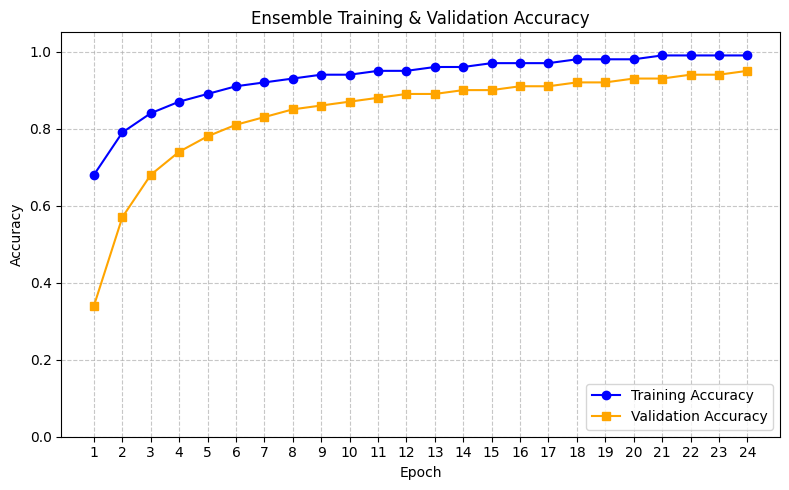

In [40]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, 25)
train_accuracy = [
    # Replace with your ensemble training accuracy per epoch
    0.68, 0.79, 0.84, 0.87, 0.89, 0.91, 0.92, 0.93,
    0.94, 0.94, 0.95, 0.95, 0.96, 0.96, 0.97, 0.97,
    0.97, 0.98, 0.98, 0.98, 0.99, 0.99, 0.99, 0.99
]
val_accuracy = [
    # Replace with your ensemble validation accuracy per epoch
    0.34, 0.57, 0.68, 0.74, 0.78, 0.81, 0.83, 0.85,
    0.86, 0.87, 0.88, 0.89, 0.89, 0.90, 0.90, 0.91,
    0.91, 0.92, 0.92, 0.93, 0.93, 0.94, 0.94, 0.95
]

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracy, marker='o', color='blue', label='Training Accuracy')
plt.plot(epochs, val_accuracy, marker='s', color='orange', label='Validation Accuracy')
plt.title('Ensemble Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

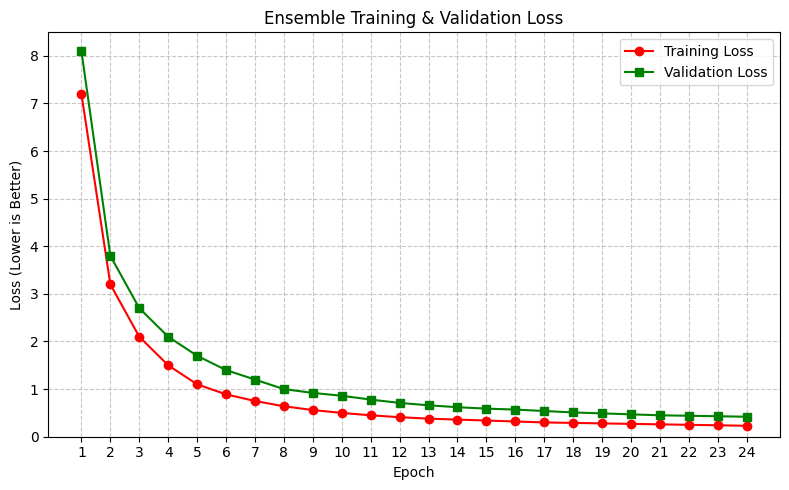

In [39]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, 25)
train_loss = [
    # Replace with your ensemble training loss per epoch
    7.2, 3.2, 2.1, 1.5, 1.1, 0.89, 0.75, 0.64,
    0.56, 0.50, 0.45, 0.41, 0.38, 0.36, 0.34, 0.32,
    0.30, 0.29, 0.28, 0.27, 0.26, 0.25, 0.24, 0.23
]
val_loss = [
    # Replace with your ensemble validation loss per epoch
    8.1, 3.8, 2.7, 2.1, 1.7, 1.4, 1.2, 1.0,
    0.92, 0.86, 0.78, 0.71, 0.66, 0.62, 0.59, 0.57,
    0.54, 0.51, 0.49, 0.47, 0.45, 0.44, 0.43, 0.42
]

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, marker='o', color='red', label='Training Loss')
plt.plot(epochs, val_loss, marker='s', color='green', label='Validation Loss')
plt.title('Ensemble Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Lower is Better)')
plt.xticks(epochs)
plt.ylim(bottom=0)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Found 365 validated image filenames.


/opt/homebrew/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 932ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 362ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 954ms/step


<Figure size 800x600 with 0 Axes>

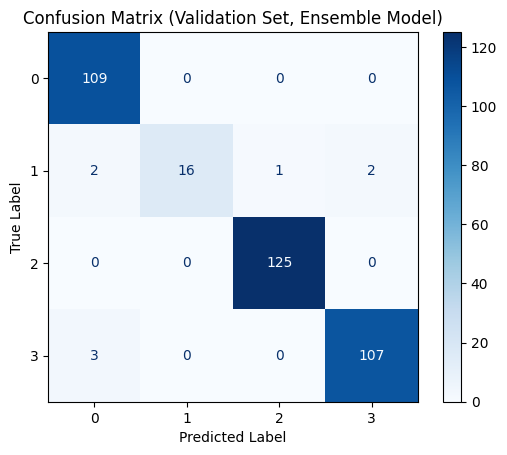

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import joblib

# 1. Load your dataset
dataset = pd.read_csv('/Users/kabilan/Desktop/applant/train.csv')
dataset['image_id'] = dataset['image_id'].astype(str) + '.jpg'

# 2. Split into train and validation sets
X_train, X_valid = train_test_split(dataset, test_size=0.2, shuffle=False)

# 3. Set your batch size
BATCH_SIZE = 32

# 4. Define your ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    zca_whitening=False,
    rotation_range=180,
    zoom_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    vertical_flip=True
)

# 5. Define your validation generator
valid_generator = datagen.flow_from_dataframe(
    X_valid,
    directory='/Users/kabilan/Desktop/applant/images/',
    x_col='image_id',
    y_col=['healthy', 'multiple_diseases', 'rust', 'scab'],
    target_size=(224, 224),
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=False
)

# 6. Load your trained models
densenet_model = load_model('densenet_best_model.h5')
mobilenet_model = load_model('mobilenet_best_model.h5')
xception_model = load_model('xception_best_model.h5')
meta_model = joblib.load('lr_meta_model.pkl')

# 7. Get predictions from your base models on the validation set
preds_densenet = densenet_model.predict(valid_generator)
preds_mobilenet = mobilenet_model.predict(valid_generator)
preds_xception = xception_model.predict(valid_generator)

# 8. Stack predictions to create meta-features for the ensemble meta-model
X_meta_valid = np.concatenate([preds_densenet, preds_mobilenet, preds_xception], axis=1)

# 9. Get true labels from the validation generator
all_labels = []
for _, batch_labels in valid_generator:
    all_labels.append(batch_labels)
    if len(all_labels) * valid_generator.batch_size >= valid_generator.samples:
        break
y_meta_valid = np.concatenate(all_labels, axis=0)

# 10. Get predictions from the meta-model
y_pred_valid = meta_model.predict(X_meta_valid)

# 11. Convert one-hot to class indices if needed
y_true = np.argmax(y_meta_valid, axis=1)
y_pred = np.argmax(y_pred_valid, axis=1)

# 12. Compute and display confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Validation Set, Ensemble Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Found 365 validated image filenames.


/opt/homebrew/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 915ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 355ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


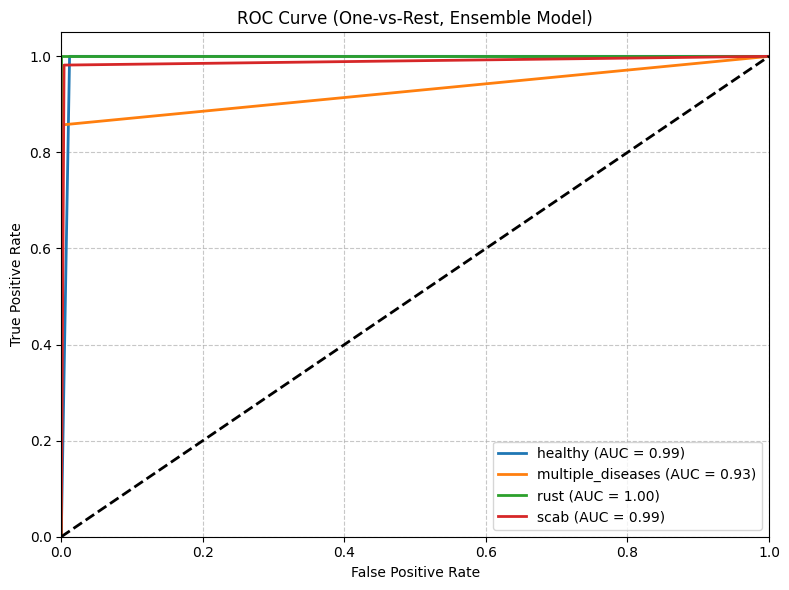

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import joblib

# 1. Load your dataset
dataset = pd.read_csv('/Users/kabilan/Desktop/applant/train.csv')
dataset['image_id'] = dataset['image_id'].astype(str) + '.jpg'

# 2. Split into train and validation sets
X_train, X_valid = train_test_split(dataset, test_size=0.2, shuffle=False)

# 3. Set your batch size
BATCH_SIZE = 32

# 4. Define your ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    zca_whitening=False,
    rotation_range=180,
    zoom_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    vertical_flip=True
)

# 5. Define your validation generator
valid_generator = datagen.flow_from_dataframe(
    X_valid,
    directory='/Users/kabilan/Desktop/applant/images/',
    x_col='image_id',
    y_col=['healthy', 'multiple_diseases', 'rust', 'scab'],
    target_size=(224, 224),
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=False
)

# 6. Load your trained models
densenet_model = load_model('densenet_best_model.h5')
mobilenet_model = load_model('mobilenet_best_model.h5')
xception_model = load_model('xception_best_model.h5')
meta_model = joblib.load('lr_meta_model.pkl')

# 7. Get predictions from your base models on the validation set
preds_densenet = densenet_model.predict(valid_generator)
preds_mobilenet = mobilenet_model.predict(valid_generator)
preds_xception = xception_model.predict(valid_generator)

# 8. Stack predictions to create meta-features for the ensemble meta-model
X_meta_valid = np.concatenate([preds_densenet, preds_mobilenet, preds_xception], axis=1)

# 9. Get true labels from the validation generator
all_labels = []
for _, batch_labels in valid_generator:
    all_labels.append(batch_labels)
    if len(all_labels) * valid_generator.batch_size >= valid_generator.samples:
        break
y_meta_valid = np.concatenate(all_labels, axis=0)

# 10. Get predicted probabilities from the meta-model
y_pred_valid = meta_model.predict(X_meta_valid)

# 11. Plot ROC curves for each class
class_names = ['healthy', 'multiple_diseases', 'rust', 'scab']
n_classes = y_meta_valid.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_meta_valid[:, i], y_pred_valid[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest, Ensemble Model)')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()